# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

In [4]:
dom.head()

,ds,y,seat
0,2015-01-01,52356,59972
1,2015-01-02,47811,56277
2,2015-01-03,49555,60035
3,2015-01-04,57680,62548
4,2015-01-05,50193,58566


In [5]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2977 non-null   datetime64[ns]
 1   y       2977 non-null   int64         
 2   seat    2977 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 69.9 KB


<AxesSubplot:xlabel='ds'>

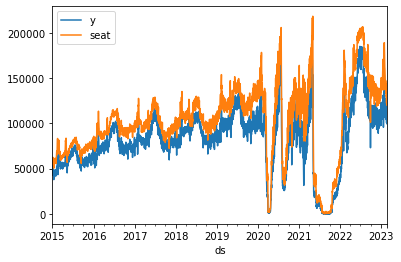

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('holidays.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
help(NeuralProphet)

Help on class NeuralProphet in module neuralprophet.forecaster:

class NeuralProphet(builtins.object)
 |  NeuralProphet(growth: Literal['off', 'linear', 'discontinuous'] = 'linear', changepoints: Optional[list] = None, n_changepoints: int = 10, changepoints_range: float = 0.8, trend_reg: float = 0, trend_reg_threshold: Union[bool, float, NoneType] = False, trend_global_local: str = 'global', yearly_seasonality: Union[Literal['auto'], bool, int] = 'auto', weekly_seasonality: Union[Literal['auto'], bool, int] = 'auto', daily_seasonality: Union[Literal['auto'], bool, int] = 'auto', seasonality_mode: Literal['additive', 'multiplicative'] = 'additive', seasonality_reg: float = 0, season_global_local: Literal['global', 'local'] = 'global', n_forecasts: int = 1, n_lags: int = 0, num_hidden_layers: int = 0, d_hidden: Optional[int] = None, ar_reg: Optional[float] = None, learning_rate: Optional[float] = None, epochs: Optional[int] = None, batch_size: Optional[int] = None, loss_func: Union[str, 

In [12]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,10),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,20),
        'n_lags':trial.suggest_int('n_lags',1,365*3),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        #'newer_samples_weight':trial.suggest_float('newer_samples_weight',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,5),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3)
    }
    lagged_regressor_params = {'regularization':trial.suggest_float('regularization',0,1)}
    
    # Create the model
    optuna_model = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')  
    optuna_model.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')
    optuna_model.add_lagged_regressor('seat', **lagged_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [13]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-03-02 09:07:46,569] A new study created in memory with name: no-name-cac3218a-c2c9-4bc1-896d-4cc17e7c9588


In [14]:
# study.optimize(objective, n_trials=100)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (326)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:10:24,905] Trial 0 finished with value: 69141.0 and parameters: {'trend_reg': 6.723113307749288, 'seasonality_reg': 4.931976152481779, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 12, 'n_lags': 326, 'ar_reg': 0.46695720506953253, 'learning_rate': 4.95314636995451, 'num_hidden_layers': 0, 'regularization': 0.7697930281899398}. Best is trial 0 with value: 69141.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (575)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 57it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:12:54,895] Trial 1 finished with value: 368134.0 and parameters: {'trend_reg': 7.467924242842003, 'seasonality_reg': 3.8366454697161556, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'weekly_seasonality': 20, 'n_lags': 575, 'ar_reg': 0.9361309329775258, 'learning_rate': 4.066728755497863, 'num_hidden_layers': 0, 'regularization': 0.5543457845906854}. Best is trial 0 with value: 69141.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (451)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 61it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:15:07,300] Trial 2 finished with value: 170841.0 and parameters: {'trend_reg': 2.923398890475657, 'seasonality_reg': 8.179809363873163, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 2, 'n_lags': 451, 'ar_reg': 0.9686526126266715, 'learning_rate': 0.7209109835395155, 'num_hidden_layers': 0, 'regularization': 0.47665615445585996}. Best is trial 0 with value: 69141.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (1018)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.928% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.928% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:18:04,008] Trial 3 finished with value: 257479.0 and parameters: {'trend_reg': 0.7770607521635486, 'seasonality_reg': 2.426933437092893, 'seasonality_mode': 'additive', 'yearly_seasonality': 27, 'weekly_seasonality': 4, 'n_lags': 1018, 'ar_reg': 5.420876988179221, 'learning_rate': 0.20975089793990523, 'num_hidden_layers': 2, 'regularization': 0.6401425405143248}. Best is trial 0 with value: 69141.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (602)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 56it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:21:02,618] Trial 4 finished with value: 20196.0 and parameters: {'trend_reg': 8.00678097830046, 'seasonality_reg': 8.365696631737041, 'seasonality_mode': 'additive', 'yearly_seasonality': 24, 'weekly_seasonality': 6, 'n_lags': 602, 'ar_reg': 3.773337872453968, 'learning_rate': 1.0194380115679886, 'num_hidden_layers': 3, 'regularization': 0.9391774228853117}. Best is trial 4 with value: 20196.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (703)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.906% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.906% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 53it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:23:56,915] Trial 5 finished with value: 20380.0 and parameters: {'trend_reg': 8.375098432159971, 'seasonality_reg': 4.38461441839196, 'seasonality_mode': 'additive', 'yearly_seasonality': 12, 'weekly_seasonality': 9, 'n_lags': 703, 'ar_reg': 9.7645132221686, 'learning_rate': 3.5267365078750386, 'num_hidden_layers': 2, 'regularization': 0.20538671086664506}. Best is trial 4 with value: 20196.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (343)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:27:10,167] Trial 6 finished with value: 20906.0 and parameters: {'trend_reg': 2.93135806422597, 'seasonality_reg': 1.6840997329118812, 'seasonality_mode': 'additive', 'yearly_seasonality': 39, 'weekly_seasonality': 1, 'n_lags': 343, 'ar_reg': 0.489126869760389, 'learning_rate': 4.373979691374203, 'num_hidden_layers': 2, 'regularization': 0.826558523971149}. Best is trial 4 with value: 20196.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (901)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.921% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.921% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 47it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:30:18,452] Trial 7 finished with value: 1196782.0 and parameters: {'trend_reg': 9.183563138936316, 'seasonality_reg': 1.6158727024981934, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 15, 'n_lags': 901, 'ar_reg': 2.3526653942787257, 'learning_rate': 0.5285945052378606, 'num_hidden_layers': 2, 'regularization': 0.24365630403016658}. Best is trial 4 with value: 20196.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (179)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:32:56,109] Trial 8 finished with value: 18945.0 and parameters: {'trend_reg': 8.26963766824501, 'seasonality_reg': 4.70873922914925, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 6, 'n_lags': 179, 'ar_reg': 2.328241446167479, 'learning_rate': 2.7225426462097873, 'num_hidden_layers': 1, 'regularization': 0.7446472519957872}. Best is trial 8 with value: 18945.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (117)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:36:02,870] Trial 9 finished with value: 19223.0 and parameters: {'trend_reg': 6.481940045150245, 'seasonality_reg': 7.723372542380457, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 20, 'n_lags': 117, 'ar_reg': 4.14941284161412, 'learning_rate': 0.7739460456125055, 'num_hidden_layers': 2, 'regularization': 0.8068766138390322}. Best is trial 8 with value: 18945.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (60)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:38:08,970] Trial 10 finished with value: 18227.0 and parameters: {'trend_reg': 4.862223554813209, 'seasonality_reg': 6.260365290152034, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 8, 'n_lags': 60, 'ar_reg': 6.161359721478034, 'learning_rate': 2.334133758747457, 'num_hidden_layers': 1, 'regularization': 0.42342746178093477}. Best is trial 10 with value: 18227.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (42)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.754% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.754% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:40:11,739] Trial 11 finished with value: 18119.0 and parameters: {'trend_reg': 4.4047488755799975, 'seasonality_reg': 6.366583029484113, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 8, 'n_lags': 42, 'ar_reg': 6.837014863548054, 'learning_rate': 2.282703310928876, 'num_hidden_layers': 1, 'regularization': 0.38255236262525505}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (11)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.734% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.734% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:42:14,082] Trial 12 finished with value: 18151.0 and parameters: {'trend_reg': 4.576437084943687, 'seasonality_reg': 6.347551013914456, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'n_lags': 11, 'ar_reg': 7.224664567895566, 'learning_rate': 1.9593499797271277, 'num_hidden_layers': 1, 'regularization': 0.3969590662083109}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (7)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.731% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.731% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:44:48,550] Trial 13 finished with value: 18319.0 and parameters: {'trend_reg': 4.925916849291945, 'seasonality_reg': 9.999105924610591, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 12, 'n_lags': 7, 'ar_reg': 8.014097092184898, 'learning_rate': 1.784613443431125, 'num_hidden_layers': 1, 'regularization': 0.0001748519866672793}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (243)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:47:46,222] Trial 14 finished with value: 19529.0 and parameters: {'trend_reg': 3.427508194690936, 'seasonality_reg': 6.367674204421199, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 243, 'ar_reg': 7.0543768126269875, 'learning_rate': 1.7987303101286938, 'num_hidden_layers': 1, 'regularization': 0.3264135204121042}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (28)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.746% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.746% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:50:19,658] Trial 15 finished with value: 20252.0 and parameters: {'trend_reg': 1.107659999572721, 'seasonality_reg': 6.25818611939244, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 11, 'n_lags': 28, 'ar_reg': 8.660019133243592, 'learning_rate': 3.185853082578281, 'num_hidden_layers': 3, 'regularization': 0.11087063387096197}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (232)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:53:18,570] Trial 16 finished with value: 19700.0 and parameters: {'trend_reg': 3.8592512696498464, 'seasonality_reg': 3.3437928556334886, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 15, 'n_lags': 232, 'ar_reg': 6.881669558317799, 'learning_rate': 1.6389180437476298, 'num_hidden_layers': 1, 'regularization': 0.35960237569890613}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (403)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.87% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.87% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 62it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:54:59,662] Trial 17 finished with value: 94087.0 and parameters: {'trend_reg': 5.92738355568111, 'seasonality_reg': 7.123316041050951, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 8, 'n_lags': 403, 'ar_reg': 8.334187212709624, 'learning_rate': 2.509961444368495, 'num_hidden_layers': 0, 'regularization': 0.5779037090563984}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (839)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.917% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.917% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 48it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:57:58,282] Trial 18 finished with value: 248401.0 and parameters: {'trend_reg': 2.0760821302643544, 'seasonality_reg': 0.22949111939312594, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 5, 'n_lags': 839, 'ar_reg': 5.66072648835196, 'learning_rate': 1.2799180497886198, 'num_hidden_layers': 1, 'regularization': 0.2596901497525121}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (170)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 09:59:56,017] Trial 19 finished with value: 101678.0 and parameters: {'trend_reg': 4.103638429684504, 'seasonality_reg': 9.539519334470631, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 170, 'ar_reg': 9.956223640417912, 'learning_rate': 3.0645579222099077, 'num_hidden_layers': 0, 'regularization': 0.4186425647699078}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (478)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.881% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.881% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 60it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:02:49,096] Trial 20 finished with value: 20024.0 and parameters: {'trend_reg': 5.765046717333444, 'seasonality_reg': 5.780783545919924, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 13, 'n_lags': 478, 'ar_reg': 7.1523773100216435, 'learning_rate': 2.15418406898903, 'num_hidden_layers': 1, 'regularization': 0.1446789784219482}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (93)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.782% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.782% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:04:56,765] Trial 21 finished with value: 18343.0 and parameters: {'trend_reg': 4.643440942538773, 'seasonality_reg': 6.982863544024213, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 8, 'n_lags': 93, 'ar_reg': 6.305973668637824, 'learning_rate': 2.152709417555243, 'num_hidden_layers': 1, 'regularization': 0.4575657997240494}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (56)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:07:04,277] Trial 22 finished with value: 18239.0 and parameters: {'trend_reg': 5.157860419118483, 'seasonality_reg': 5.49225039210393, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 7, 'n_lags': 56, 'ar_reg': 4.370912449657091, 'learning_rate': 2.246558530031154, 'num_hidden_layers': 1, 'regularization': 0.376245280806262}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (3)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.728% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.728% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 75it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:09:15,372] Trial 23 finished with value: 123114.0 and parameters: {'trend_reg': 2.2432682379701148, 'seasonality_reg': 8.744474631304024, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 4, 'n_lags': 3, 'ar_reg': 6.012206690280564, 'learning_rate': 1.5226038089611964, 'num_hidden_layers': 1, 'regularization': 0.6161657591797607}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (140)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:12:03,703] Trial 24 finished with value: 18723.0 and parameters: {'trend_reg': 4.425844254598728, 'seasonality_reg': 7.163203202613167, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 140, 'ar_reg': 7.922669963924976, 'learning_rate': 2.6786492255140093, 'num_hidden_layers': 2, 'regularization': 0.30924595984946546}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (270)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:14:38,467] Trial 25 finished with value: 19286.0 and parameters: {'trend_reg': 5.547408576246074, 'seasonality_reg': 6.035248065778635, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 8, 'n_lags': 270, 'ar_reg': 4.9046565934889585, 'learning_rate': 3.167882986920028, 'num_hidden_layers': 1, 'regularization': 0.489684534943317}. Best is trial 11 with value: 18119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (108)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:16:53,343] Trial 26 finished with value: 16814.0 and parameters: {'trend_reg': 6.57524971879661, 'seasonality_reg': 6.726484800938223, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 13, 'n_lags': 108, 'ar_reg': 9.198352638541554, 'learning_rate': 2.115748381553713, 'num_hidden_layers': 0, 'regularization': 0.3971943323941488}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (219)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:19:19,166] Trial 27 finished with value: 84139.0 and parameters: {'trend_reg': 9.886450040093372, 'seasonality_reg': 8.990193967834943, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 17, 'n_lags': 219, 'ar_reg': 8.843663287237295, 'learning_rate': 1.358177800559176, 'num_hidden_layers': 0, 'regularization': 0.5457112036689192}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (317)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:21:36,273] Trial 28 finished with value: 94100.0 and parameters: {'trend_reg': 6.877360938115175, 'seasonality_reg': 7.780228625630798, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 13, 'n_lags': 317, 'ar_reg': 9.242346769024815, 'learning_rate': 3.627319328063351, 'num_hidden_layers': 0, 'regularization': 0.6562861262467514}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (358)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:24:18,035] Trial 29 finished with value: 104115.0 and parameters: {'trend_reg': 6.419632376410233, 'seasonality_reg': 5.264833219670633, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 17, 'n_lags': 358, 'ar_reg': 7.606635763742801, 'learning_rate': 1.955492612423119, 'num_hidden_layers': 0, 'regularization': 0.16841009837404478}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (110)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:26:39,544] Trial 30 finished with value: 16876.0 and parameters: {'trend_reg': 7.163386512200606, 'seasonality_reg': 4.819523865001461, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 12, 'n_lags': 110, 'ar_reg': 9.232036163165095, 'learning_rate': 4.875006993114297, 'num_hidden_layers': 0, 'regularization': 0.30781164225344804}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (109)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:29:00,180] Trial 31 finished with value: 16967.0 and parameters: {'trend_reg': 7.064750746614276, 'seasonality_reg': 4.858958285768699, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 12, 'n_lags': 109, 'ar_reg': 9.09496749205384, 'learning_rate': 4.828575696581574, 'num_hidden_layers': 0, 'regularization': 0.2842622038158433}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (112)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:31:19,974] Trial 32 finished with value: 16852.0 and parameters: {'trend_reg': 7.161113015079409, 'seasonality_reg': 4.036208480418402, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 12, 'n_lags': 112, 'ar_reg': 9.118976633201928, 'learning_rate': 4.791589363585634, 'num_hidden_layers': 0, 'regularization': 0.292915963124819}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (124)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:33:42,315] Trial 33 finished with value: 18179.0 and parameters: {'trend_reg': 6.862097854211496, 'seasonality_reg': 3.863082745106276, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 13, 'n_lags': 124, 'ar_reg': 9.594618671263337, 'learning_rate': 4.999735330719612, 'num_hidden_layers': 0, 'regularization': 0.05561432951612921}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (289)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:36:10,470] Trial 34 finished with value: 142227.0 and parameters: {'trend_reg': 7.418881285003589, 'seasonality_reg': 3.0257564633322325, 'seasonality_mode': 'additive', 'yearly_seasonality': 28, 'weekly_seasonality': 14, 'n_lags': 289, 'ar_reg': 8.981431869672654, 'learning_rate': 4.5529089698338465, 'num_hidden_layers': 0, 'regularization': 0.29323692752150005}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (182)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:38:30,126] Trial 35 finished with value: 87760.0 and parameters: {'trend_reg': 7.69162942688749, 'seasonality_reg': 4.270813577118841, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 12, 'n_lags': 182, 'ar_reg': 8.423386429385772, 'learning_rate': 4.619959054580504, 'num_hidden_layers': 0, 'regularization': 0.23143810946172333}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (527)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.888% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.888% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 58it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:41:01,653] Trial 36 finished with value: 189782.0 and parameters: {'trend_reg': 9.0480806779895, 'seasonality_reg': 4.9050745510266, 'seasonality_mode': 'additive', 'yearly_seasonality': 30, 'weekly_seasonality': 17, 'n_lags': 527, 'ar_reg': 9.375922502464663, 'learning_rate': 4.109946366869998, 'num_hidden_layers': 0, 'regularization': 0.18477526472076622}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (624)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 55it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:43:13,586] Trial 37 finished with value: 149987.0 and parameters: {'trend_reg': 7.30380796775823, 'seasonality_reg': 3.5241453051640006, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 11, 'n_lags': 624, 'ar_reg': 9.077095993738288, 'learning_rate': 4.739664500717644, 'num_hidden_layers': 0, 'regularization': 0.2804488621982118}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (1089)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.931% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.931% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 41it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:45:55,220] Trial 38 finished with value: 855844.0 and parameters: {'trend_reg': 8.69317616460036, 'seasonality_reg': 2.6081400351194004, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'weekly_seasonality': 14, 'n_lags': 1089, 'ar_reg': 9.999583631871161, 'learning_rate': 4.0926437373210325, 'num_hidden_layers': 0, 'regularization': 0.10361463187677666}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (392)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.868% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.868% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 62it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:48:26,622] Trial 39 finished with value: 93604.0 and parameters: {'trend_reg': 6.221900859400883, 'seasonality_reg': 4.248049230476805, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 16, 'n_lags': 392, 'ar_reg': 7.9709743832902, 'learning_rate': 4.303365326580592, 'num_hidden_layers': 0, 'regularization': 0.32251780117186635}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (93)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.782% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.782% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:50:49,791] Trial 40 finished with value: 17564.0 and parameters: {'trend_reg': 7.784905155098434, 'seasonality_reg': 1.938900280703701, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 18, 'n_lags': 93, 'ar_reg': 8.518295611533548, 'learning_rate': 3.7263622449504483, 'num_hidden_layers': 0, 'regularization': 0.971935068461302}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (95)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:53:14,197] Trial 41 finished with value: 17779.0 and parameters: {'trend_reg': 7.8749115955283004, 'seasonality_reg': 1.6680507904030146, 'seasonality_mode': 'additive', 'yearly_seasonality': 20, 'weekly_seasonality': 19, 'n_lags': 95, 'ar_reg': 9.407123647839956, 'learning_rate': 3.7983284527621266, 'num_hidden_layers': 0, 'regularization': 0.9768692584224795}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (193)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:55:46,002] Trial 42 finished with value: 20110.0 and parameters: {'trend_reg': 7.224710727163974, 'seasonality_reg': 0.47268928580553826, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'weekly_seasonality': 19, 'n_lags': 193, 'ar_reg': 8.87359233017439, 'learning_rate': 4.801470972034609, 'num_hidden_layers': 0, 'regularization': 0.7291035877381962}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (136)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 10:58:03,722] Trial 43 finished with value: 17684.0 and parameters: {'trend_reg': 8.284001843665097, 'seasonality_reg': 4.917463493059227, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 12, 'n_lags': 136, 'ar_reg': 8.41608707169165, 'learning_rate': 4.405297034545412, 'num_hidden_layers': 0, 'regularization': 0.4799994613958672}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (81)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:00:27,625] Trial 44 finished with value: 17821.0 and parameters: {'trend_reg': 6.9044471494653505, 'seasonality_reg': 1.2609165728670195, 'seasonality_mode': 'additive', 'yearly_seasonality': 25, 'weekly_seasonality': 14, 'n_lags': 81, 'ar_reg': 7.681193347495586, 'learning_rate': 3.7876131303280127, 'num_hidden_layers': 0, 'regularization': 0.8470178015177481}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (166)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:03:22,657] Trial 45 finished with value: 19491.0 and parameters: {'trend_reg': 8.833033952429929, 'seasonality_reg': 2.4843481956995457, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'weekly_seasonality': 11, 'n_lags': 166, 'ar_reg': 2.3747730337420365, 'learning_rate': 4.87479763469487, 'num_hidden_layers': 3, 'regularization': 0.23316247672706594}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (286)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:05:33,374] Trial 46 finished with value: 125134.0 and parameters: {'trend_reg': 9.60231594840275, 'seasonality_reg': 4.578632662289518, 'seasonality_mode': 'additive', 'yearly_seasonality': 27, 'weekly_seasonality': 9, 'n_lags': 286, 'ar_reg': 9.543610297398834, 'learning_rate': 4.356871214800731, 'num_hidden_layers': 0, 'regularization': 0.3344053154177179}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (82)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:07:59,296] Trial 47 finished with value: 210243.0 and parameters: {'trend_reg': 7.988894037112221, 'seasonality_reg': 5.443088666191131, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 16, 'n_lags': 82, 'ar_reg': 8.20529191843231, 'learning_rate': 0.07479786898830687, 'num_hidden_layers': 0, 'regularization': 0.8994347159492797}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (692)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.905% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.905% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 53it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:10:45,531] Trial 48 finished with value: 198946.0 and parameters: {'trend_reg': 5.357869437081782, 'seasonality_reg': 3.7419490300831004, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 19, 'n_lags': 692, 'ar_reg': 3.2921434772251272, 'learning_rate': 3.41040512427391, 'num_hidden_layers': 0, 'regularization': 0.44912617528206367}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (221)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:12:59,735] Trial 49 finished with value: 79672.0 and parameters: {'trend_reg': 6.238355500791164, 'seasonality_reg': 2.142249190302461, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 12, 'n_lags': 221, 'ar_reg': 8.71731890410749, 'learning_rate': 3.8878984276945987, 'num_hidden_layers': 0, 'regularization': 0.554588799231472}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (60)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:15:29,046] Trial 50 finished with value: 17521.0 and parameters: {'trend_reg': 7.146374151440734, 'seasonality_reg': 0.9767142354216928, 'seasonality_mode': 'additive', 'yearly_seasonality': 40, 'weekly_seasonality': 9, 'n_lags': 60, 'ar_reg': 9.650967655716801, 'learning_rate': 4.997080062360444, 'num_hidden_layers': 0, 'regularization': 0.685942942286166}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (51)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.76% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.76% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:17:59,757] Trial 51 finished with value: 17835.0 and parameters: {'trend_reg': 7.652583718424158, 'seasonality_reg': 1.0129609472845376, 'seasonality_mode': 'additive', 'yearly_seasonality': 40, 'weekly_seasonality': 9, 'n_lags': 51, 'ar_reg': 9.703902293278231, 'learning_rate': 4.563153682070263, 'num_hidden_layers': 0, 'regularization': 0.6987838281972714}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (132)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.799% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.799% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:20:15,235] Trial 52 finished with value: 18197.0 and parameters: {'trend_reg': 7.118937470666265, 'seasonality_reg': 0.7144614910980094, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 11, 'n_lags': 132, 'ar_reg': 9.156798664260595, 'learning_rate': 4.981483238988009, 'num_hidden_layers': 0, 'regularization': 0.7916184755842934}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (29)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.746% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.746% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:22:57,417] Trial 53 finished with value: 18129.0 and parameters: {'trend_reg': 6.566007925574243, 'seasonality_reg': 1.9866776634392331, 'seasonality_mode': 'additive', 'yearly_seasonality': 38, 'weekly_seasonality': 13, 'n_lags': 29, 'ar_reg': 9.973200347107728, 'learning_rate': 4.695320513894148, 'num_hidden_layers': 0, 'regularization': 0.867500950963786}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (110)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:25:20,197] Trial 54 finished with value: 17941.0 and parameters: {'trend_reg': 8.358157645435863, 'seasonality_reg': 6.744216384991855, 'seasonality_mode': 'additive', 'yearly_seasonality': 33, 'weekly_seasonality': 9, 'n_lags': 110, 'ar_reg': 8.5881643844189, 'learning_rate': 4.132493791671591, 'num_hidden_layers': 0, 'regularization': 0.9918894907393053}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (163)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:27:21,770] Trial 55 finished with value: 98287.0 and parameters: {'trend_reg': 5.886059695917919, 'seasonality_reg': 3.03182253151389, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 10, 'n_lags': 163, 'ar_reg': 7.6516679965624395, 'learning_rate': 4.4667139115365835, 'num_hidden_layers': 0, 'regularization': 0.3561801888418982}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (211)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:29:45,821] Trial 56 finished with value: 23322.0 and parameters: {'trend_reg': 7.527126714251087, 'seasonality_reg': 1.3013423269771, 'seasonality_mode': 'additive', 'yearly_seasonality': 37, 'weekly_seasonality': 6, 'n_lags': 211, 'ar_reg': 6.54972463242331, 'learning_rate': 4.804247075218298, 'num_hidden_layers': 0, 'regularization': 0.40694541769646875}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (65)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.767% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.767% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:32:05,772] Trial 57 finished with value: 70881.0 and parameters: {'trend_reg': 0.22502351474677518, 'seasonality_reg': 0.11655578806563727, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 14, 'n_lags': 65, 'ar_reg': 9.276880578975444, 'learning_rate': 4.210585121414539, 'num_hidden_layers': 0, 'regularization': 0.5313183270225222}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (858)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.918% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.918% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 48it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:34:59,843] Trial 58 finished with value: 21364.0 and parameters: {'trend_reg': 8.091554309326883, 'seasonality_reg': 5.7522562334922425, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 2, 'n_lags': 858, 'ar_reg': 7.324034398733329, 'learning_rate': 2.8403335569977903, 'num_hidden_layers': 2, 'regularization': 0.935527420259527}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (16)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:37:33,822] Trial 59 finished with value: 18516.0 and parameters: {'trend_reg': 6.107817326212357, 'seasonality_reg': 2.894324657465509, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 12, 'n_lags': 16, 'ar_reg': 0.17604707314242596, 'learning_rate': 4.997259091632366, 'num_hidden_layers': 1, 'regularization': 0.25673379610224345}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (238)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:40:33,897] Trial 60 finished with value: 285859.0 and parameters: {'trend_reg': 6.655019031118503, 'seasonality_reg': 4.195695604387753, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'weekly_seasonality': 16, 'n_lags': 238, 'ar_reg': 8.198493815644003, 'learning_rate': 3.407326739631205, 'num_hidden_layers': 1, 'regularization': 0.21156506772369965}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (141)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:42:46,430] Trial 61 finished with value: 18207.0 and parameters: {'trend_reg': 8.237222384190694, 'seasonality_reg': 5.027077713603868, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 12, 'n_lags': 141, 'ar_reg': 8.551376447680987, 'learning_rate': 4.401857553564157, 'num_hidden_layers': 0, 'regularization': 0.5073951894243205}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (106)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.788% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.788% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:44:57,152] Trial 62 finished with value: 17751.0 and parameters: {'trend_reg': 7.132437356237926, 'seasonality_reg': 4.7832592242214504, 'seasonality_mode': 'additive', 'yearly_seasonality': 25, 'weekly_seasonality': 11, 'n_lags': 106, 'ar_reg': 9.65430364684137, 'learning_rate': 4.666667601168619, 'num_hidden_layers': 0, 'regularization': 0.36068639732846874}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (53)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:47:12,084] Trial 63 finished with value: 17463.0 and parameters: {'trend_reg': 8.73045549033622, 'seasonality_reg': 5.221489274752061, 'seasonality_mode': 'additive', 'yearly_seasonality': 21, 'weekly_seasonality': 13, 'n_lags': 53, 'ar_reg': 9.022999267054134, 'learning_rate': 4.514465320181331, 'num_hidden_layers': 0, 'regularization': 0.4447817682852099}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (60)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:49:34,215] Trial 64 finished with value: 17721.0 and parameters: {'trend_reg': 8.701193372153723, 'seasonality_reg': 6.628506423372642, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 13, 'n_lags': 60, 'ar_reg': 9.114907769983713, 'learning_rate': 4.844726242349793, 'num_hidden_layers': 0, 'regularization': 0.43258088050195953}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (2)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.728% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.728% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 75it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:51:49,760] Trial 65 finished with value: 17664.0 and parameters: {'trend_reg': 7.813589737085399, 'seasonality_reg': 7.480509206000781, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 15, 'n_lags': 2, 'ar_reg': 8.922887835312036, 'learning_rate': 3.9767628035260283, 'num_hidden_layers': 0, 'regularization': 0.39915511458122294}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (258)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:53:57,124] Trial 66 finished with value: 125760.0 and parameters: {'trend_reg': 9.420439736402553, 'seasonality_reg': 5.853492216530705, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'weekly_seasonality': 10, 'n_lags': 258, 'ar_reg': 9.60767155879357, 'learning_rate': 4.563943609639753, 'num_hidden_layers': 0, 'regularization': 0.6426490241404405}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (39)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.752% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.752% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:55:58,519] Trial 67 finished with value: 17076.0 and parameters: {'trend_reg': 8.536206824650916, 'seasonality_reg': 5.289268129695072, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 7, 'n_lags': 39, 'ar_reg': 8.68044271489894, 'learning_rate': 4.6854174774334085, 'num_hidden_layers': 0, 'regularization': 0.6040210364274982}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (39)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.752% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.752% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 11:58:01,170] Trial 68 finished with value: 17007.0 and parameters: {'trend_reg': 9.206228568317623, 'seasonality_reg': 5.263976470897191, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 7, 'n_lags': 39, 'ar_reg': 9.40849615141087, 'learning_rate': 4.700173346882112, 'num_hidden_layers': 0, 'regularization': 0.5733000843179155}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (35)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 12:00:30,972] Trial 69 finished with value: 18339.0 and parameters: {'trend_reg': 9.801802361674495, 'seasonality_reg': 5.456516005585335, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 7, 'n_lags': 35, 'ar_reg': 8.135000967449722, 'learning_rate': 4.716414020889962, 'num_hidden_layers': 1, 'regularization': 0.6095958411413736}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (153)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 12:02:41,902] Trial 70 finished with value: 18901.0 and parameters: {'trend_reg': 9.181084319446146, 'seasonality_reg': 4.523727597887665, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 5, 'n_lags': 153, 'ar_reg': 8.775263907890796, 'learning_rate': 4.289598759055875, 'num_hidden_layers': 0, 'regularization': 0.5959926453848372}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (44)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.756% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.756% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:32:00,982] Trial 71 finished with value: 17055.0 and parameters: {'trend_reg': 8.594520861091175, 'seasonality_reg': 3.95585945636969, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 7, 'n_lags': 44, 'ar_reg': 9.342868304329707, 'learning_rate': 4.852989497235497, 'num_hidden_layers': 0, 'regularization': 0.6731717717448864}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (1)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 75it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:34:06,901] Trial 72 finished with value: 17317.0 and parameters: {'trend_reg': 8.609419478931558, 'seasonality_reg': 4.06236794549815, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 6, 'n_lags': 1, 'ar_reg': 9.156422405687485, 'learning_rate': 4.810106443537123, 'num_hidden_layers': 0, 'regularization': 0.5155304051023446}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (29)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.746% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.746% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:36:16,193] Trial 73 finished with value: 17438.0 and parameters: {'trend_reg': 8.555998909283485, 'seasonality_reg': 3.8392446383027576, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 7, 'n_lags': 29, 'ar_reg': 9.376570625332336, 'learning_rate': 2.46517422934111, 'num_hidden_layers': 0, 'regularization': 0.5673188583449472}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (2)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.728% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.728% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 75it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:38:19,340] Trial 74 finished with value: 17431.0 and parameters: {'trend_reg': 9.415409930518777, 'seasonality_reg': 4.0952442496809525, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 6, 'n_lags': 2, 'ar_reg': 9.97048922767897, 'learning_rate': 4.8250707820821175, 'num_hidden_layers': 0, 'regularization': 0.6707620360815338}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (190)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:40:25,656] Trial 75 finished with value: 19362.0 and parameters: {'trend_reg': 8.96752868208139, 'seasonality_reg': 3.616484391072192, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 4, 'n_lags': 190, 'ar_reg': 7.84623017229248, 'learning_rate': 4.70086416481709, 'num_hidden_layers': 0, 'regularization': 0.5096670982540924}. Best is trial 26 with value: 16814.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (121)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.794% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.794% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:42:30,366] Trial 76 finished with value: 16775.0 and parameters: {'trend_reg': 8.490643005801378, 'seasonality_reg': 3.3999775444644396, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 5, 'n_lags': 121, 'ar_reg': 9.275355724952528, 'learning_rate': 4.8526177784278435, 'num_hidden_layers': 0, 'regularization': 0.7473886239309456}. Best is trial 76 with value: 16775.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (117)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:44:35,092] Trial 77 finished with value: 16102.0 and parameters: {'trend_reg': 9.977200269401415, 'seasonality_reg': 3.3329998332677184, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 5, 'n_lags': 117, 'ar_reg': 9.392653962655466, 'learning_rate': 0.9014617232930384, 'num_hidden_layers': 0, 'regularization': 0.7592396072858911}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (109)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:46:43,570] Trial 78 finished with value: 16167.0 and parameters: {'trend_reg': 9.907086967148798, 'seasonality_reg': 2.8031083102121137, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 3, 'n_lags': 109, 'ar_reg': 9.438149617417, 'learning_rate': 0.5580592304855065, 'num_hidden_layers': 0, 'regularization': 0.7527138680456346}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (115)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.792% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.792% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:49:27,442] Trial 79 finished with value: 19193.0 and parameters: {'trend_reg': 9.50403368267012, 'seasonality_reg': 3.268368850538702, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 1, 'n_lags': 115, 'ar_reg': 0.9215294539353023, 'learning_rate': 0.48186937612832254, 'num_hidden_layers': 1, 'regularization': 0.7581522184100746}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (317)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:52:43,524] Trial 80 finished with value: 19319.0 and parameters: {'trend_reg': 9.928553809254804, 'seasonality_reg': 2.7228496118496808, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 3, 'n_lags': 317, 'ar_reg': 9.817990511443167, 'learning_rate': 1.0693441343792993, 'num_hidden_layers': 3, 'regularization': 0.8059789925816473}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (83)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:54:54,314] Trial 81 finished with value: 17413.0 and parameters: {'trend_reg': 9.216356279684218, 'seasonality_reg': 3.491054255998846, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 5, 'n_lags': 83, 'ar_reg': 9.421160671983387, 'learning_rate': 0.6491746145662676, 'num_hidden_layers': 0, 'regularization': 0.7177942844265811}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (187)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:57:20,126] Trial 82 finished with value: 18137.0 and parameters: {'trend_reg': 9.660095830440678, 'seasonality_reg': 3.2877459148073576, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 3, 'n_lags': 187, 'ar_reg': 9.396660275800802, 'learning_rate': 0.37973287933312505, 'num_hidden_layers': 0, 'regularization': 0.7652655649633235}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (122)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 13:59:41,523] Trial 83 finished with value: 16172.0 and parameters: {'trend_reg': 9.065957928653358, 'seasonality_reg': 4.5981977351999985, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 4, 'n_lags': 122, 'ar_reg': 9.044558709871087, 'learning_rate': 0.8134081473876675, 'num_hidden_layers': 0, 'regularization': 0.275113555101296}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (154)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:01:53,305] Trial 84 finished with value: 17411.0 and parameters: {'trend_reg': 9.149214352651788, 'seasonality_reg': 4.565918439003429, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 3, 'n_lags': 154, 'ar_reg': 8.900001224519196, 'learning_rate': 1.0872153561366722, 'num_hidden_layers': 0, 'regularization': 0.2836180182213104}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (114)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.791% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.791% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:04:07,503] Trial 85 finished with value: 16562.0 and parameters: {'trend_reg': 9.994406161690666, 'seasonality_reg': 4.415491529542019, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 2, 'n_lags': 114, 'ar_reg': 8.398152265749578, 'learning_rate': 0.8318756827850554, 'num_hidden_layers': 0, 'regularization': 0.27168737978771634}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (199)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:06:22,014] Trial 86 finished with value: 19593.0 and parameters: {'trend_reg': 9.975843953506166, 'seasonality_reg': 4.857931478138605, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 2, 'n_lags': 199, 'ar_reg': 4.994767751759266, 'learning_rate': 0.8744435897258345, 'num_hidden_layers': 0, 'regularization': 0.3118079540778724}. Best is trial 77 with value: 16102.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (126)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:08:42,910] Trial 87 finished with value: 15985.0 and parameters: {'trend_reg': 9.636339075205013, 'seasonality_reg': 4.486151242849226, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 4, 'n_lags': 126, 'ar_reg': 8.397277304863213, 'learning_rate': 1.3202851143258183, 'num_hidden_layers': 0, 'regularization': 0.1800104904245046}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (117)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:11:37,473] Trial 88 finished with value: 16013.0 and parameters: {'trend_reg': 9.641016435515265, 'seasonality_reg': 2.297634006613067, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 4, 'n_lags': 117, 'ar_reg': 8.396263440812099, 'learning_rate': 1.293055082574157, 'num_hidden_layers': 0, 'regularization': 0.14142623315357417}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (948)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.924% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.924% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 45it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:15:08,815] Trial 89 finished with value: 448097.0 and parameters: {'trend_reg': 9.744686345086789, 'seasonality_reg': 3.1445630503309676, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 2, 'n_lags': 948, 'ar_reg': 7.454278436672868, 'learning_rate': 1.4509850331820955, 'num_hidden_layers': 0, 'regularization': 0.1462766547149397}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (251)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:17:56,270] Trial 90 finished with value: 24993.0 and parameters: {'trend_reg': 9.479556930072397, 'seasonality_reg': 2.2652750622999673, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 4, 'n_lags': 251, 'ar_reg': 8.452691032223868, 'learning_rate': 1.195056412076611, 'num_hidden_layers': 0, 'regularization': 0.11434334718091627}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (123)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:20:10,551] Trial 91 finished with value: 16423.0 and parameters: {'trend_reg': 8.932363091476725, 'seasonality_reg': 4.389355537705396, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 4, 'n_lags': 123, 'ar_reg': 8.3082783879458, 'learning_rate': 0.8480068926592642, 'num_hidden_layers': 0, 'regularization': 0.20319371434481787}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (135)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:22:25,152] Trial 92 finished with value: 16012.0 and parameters: {'trend_reg': 8.950742942146046, 'seasonality_reg': 4.45729904446106, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 5, 'n_lags': 135, 'ar_reg': 7.873475332574328, 'learning_rate': 0.8659274397744872, 'num_hidden_layers': 0, 'regularization': 0.1842809292237456}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (131)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.798% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.798% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:24:40,487] Trial 93 finished with value: 16078.0 and parameters: {'trend_reg': 8.931198533856003, 'seasonality_reg': 4.365569166505673, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 5, 'n_lags': 131, 'ar_reg': 7.907817953515976, 'learning_rate': 0.8057108142504709, 'num_hidden_layers': 0, 'regularization': 0.17917469708496342}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (166)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:26:55,086] Trial 94 finished with value: 17287.0 and parameters: {'trend_reg': 8.874302903229458, 'seasonality_reg': 4.4208087301109265, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 5, 'n_lags': 166, 'ar_reg': 6.955929517148007, 'learning_rate': 0.8832129336797943, 'num_hidden_layers': 0, 'regularization': 0.058645564031011316}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (134)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:29:56,907] Trial 95 finished with value: 18761.0 and parameters: {'trend_reg': 9.356572750978247, 'seasonality_reg': 3.701089080608356, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 3, 'n_lags': 134, 'ar_reg': 7.790558960026157, 'learning_rate': 0.706841158148539, 'num_hidden_layers': 2, 'regularization': 0.1849791254874519}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (78)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:32:14,751] Trial 96 finished with value: 91617.0 and parameters: {'trend_reg': 9.999374283587393, 'seasonality_reg': 2.7965767113012476, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 5, 'n_lags': 78, 'ar_reg': 8.013933331003964, 'learning_rate': 0.28680481503816657, 'num_hidden_layers': 0, 'regularization': 0.21301673981683325}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (223)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:34:26,913] Trial 97 finished with value: 23796.0 and parameters: {'trend_reg': 9.720311997051057, 'seasonality_reg': 4.33514549164375, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 4, 'n_lags': 223, 'ar_reg': 8.22843115139858, 'learning_rate': 0.9338574805304422, 'num_hidden_layers': 0, 'regularization': 0.1467394109018128}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (282)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:36:39,066] Trial 98 finished with value: 25148.0 and parameters: {'trend_reg': 9.048367583787718, 'seasonality_reg': 3.488784714738819, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 4, 'n_lags': 282, 'ar_reg': 7.524246059694773, 'learning_rate': 0.5811794505970155, 'num_hidden_layers': 0, 'regularization': 0.09080850792735108}. Best is trial 87 with value: 15985.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (176)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-02 14:38:59,910] Trial 99 finished with value: 17780.0 and parameters: {'trend_reg': 9.61590452839159, 'seasonality_reg': 4.691774174046, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 36, 'weekly_seasonality': 2, 'n_lags': 176, 'ar_reg': 5.725993329342698, 'learning_rate': 1.287487678145931, 'num_hidden_layers': 0, 'regularization': 0.12486807700735394}. Best is trial 87 with value: 15985.0.


In [15]:
# print('Number of finished trials: {}'.format(len(study.trials)))
# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))
# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 15985.0
  Params: 
    trend_reg: 9.636339075205013
    seasonality_reg: 4.486151242849226
    seasonality_mode: multiplicative
    yearly_seasonality: 29
    weekly_seasonality: 4
    n_lags: 126
    ar_reg: 8.397277304863213
    learning_rate: 1.3202851143258183
    num_hidden_layers: 0
    regularization: 0.1800104904245046


In [ ]:
params = {'trend_reg': 9.636339075205013,
              'seasonality_reg': 4.486151242849226, 
              'seasonality_mode': 'multiplicative', 
              'yearly_seasonality': 29, 
              'weekly_seasonality': 4, 
              'n_lags': 126, 
              'ar_reg': 8.397277304863213, 
              'learning_rate': 1.3202851143258183, 
              'num_hidden_layers': 0, 
              'regularization': 0.1800104904245046}

In [16]:
regularization = params.pop('regularization')

In [18]:
# params = study2.trials[4].params
# params = trial.params

In [19]:
set_random_seed(99)

In [20]:
m = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')
m.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')
m.add_lagged_regressor('seat', regularization = regularization)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (126)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 149


Training: 0it [00:00, ?it/s]

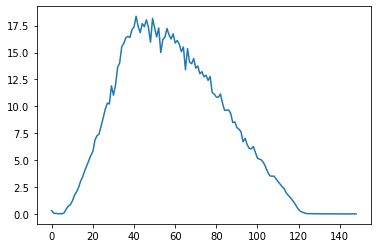

In [21]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


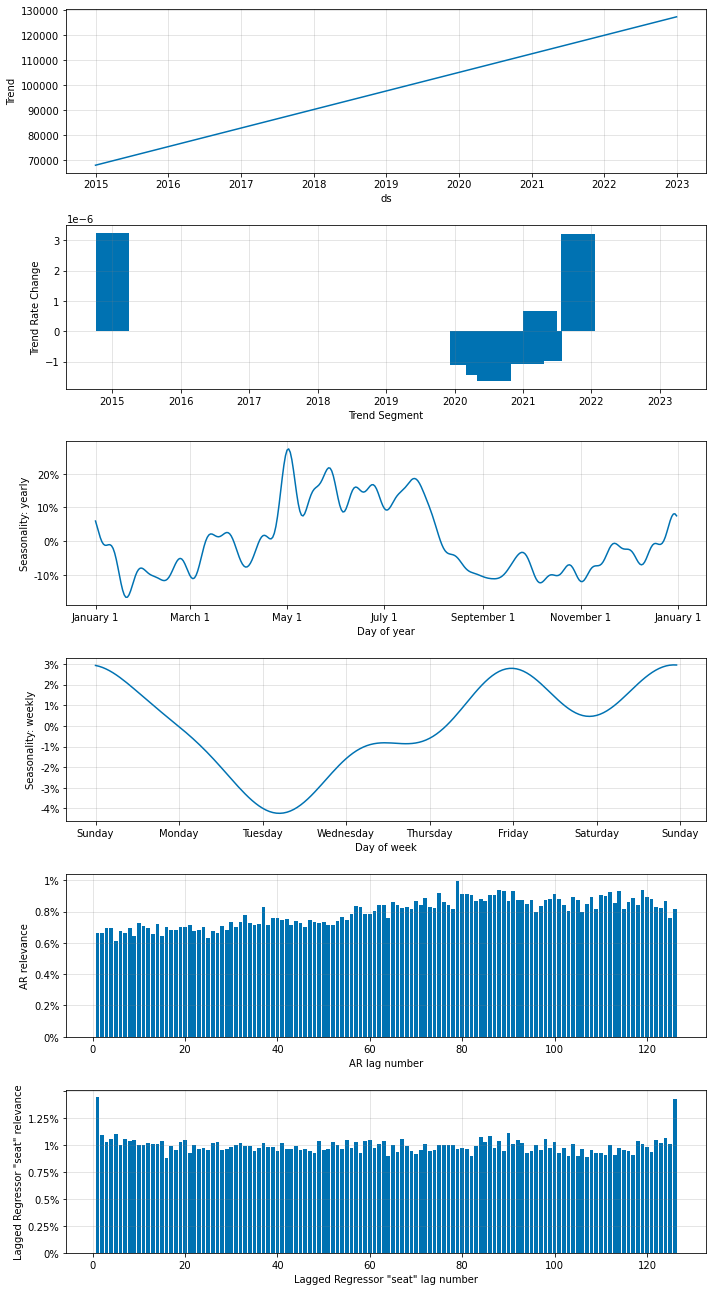

In [22]:
fig_param = m.plot_parameters()

In [23]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [24]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-02-01')]

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,Labor,Lunar,Summer
2922,2023-01-01,None,None,0,0,0,0,0,0,0
2923,2023-01-02,None,None,0,0,0,0,0,0,0
2924,2023-01-03,None,None,0,0,0,0,0,0,0
2925,2023-01-04,None,None,0,0,0,0,0,0,0
2926,2023-01-05,None,None,0,0,0,0,0,0,0
2927,2023-01-06,None,None,0,0,0,0,0,0,0
2928,2023-01-07,None,None,0,0,0,0,0,0,0
2929,2023-01-08,None,None,0,0,0,0,0,0,0
2930,2023-01-09,None,None,0,0,0,0,0,0,0
2931,2023-01-10,None,None,0,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 76it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


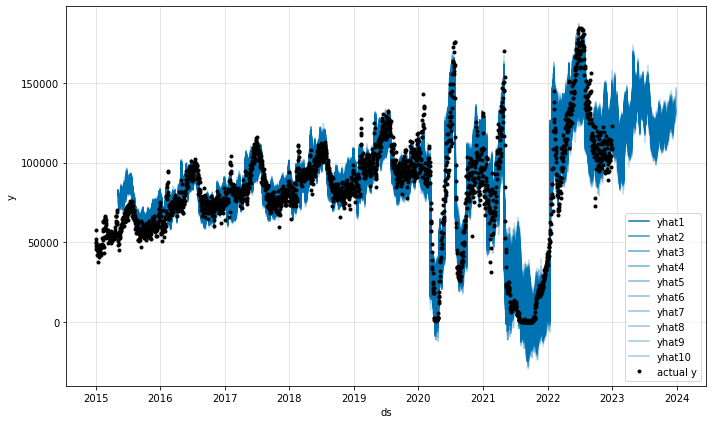

In [25]:
forecast = m.predict(future, decompose = False)
fig = m.plot(forecast)

In [26]:
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,...,yhat356,yhat357,yhat358,yhat359,yhat360,yhat361,yhat362,yhat363,yhat364,yhat365
0,2015-01-01,"52,356",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,"47,811",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,"49,555",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,"57,680",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,"50,193",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"133,801","131,844","139,771","138,646","131,521"
3283,2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"134,946","141,405","138,628","141,170"
3284,2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"146,613","142,938","147,139"
3285,2023-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"144,281","138,599"


In [27]:
latest = m.get_latest_forecast(forecast,include_history_data=True)

In [28]:
latest.to_excel('latest.xlsx')

In [29]:
forecast.to_excel('result.xlsx')

In [30]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(predicted['y'][-len(test):], predicted['yhat1'][-len(test):])).round(2)
mape = np.round(np.mean(np.abs(predicted['y'][-len(test):]-predicted['yhat1'][-len(test):])/predicted['y'][-len(test):])*100,2)
tempResults = pd.DataFrame({'Method':'neural prophet', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

NameError: name 'predicted' is not defined

In [31]:
predicted.to_excel('result.xlsx')

NameError: name 'predicted' is not defined

In [ ]:
np.mean(np.abs(predicted['y']-predicted['yhat1'])/predicted['y'])*100

In [ ]:
result = val_df.merge(latest,how = 'left', on = 'ds')

In [ ]:
result